<a href="https://colab.research.google.com/github/bhavya2810/Bhavya_INFO5731/blob/master/INFO5731_Assignment_Four.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment Four**

In this assignment, you are required to conduct topic modeling, sentiment analysis, and regression analysis.

In [1]:
!wget https://github.com/saivardhan31/saivardhanreddychalla_INFO5731_Spring2022/raw/main/sentiment-analysis-on-movie-reviews.zip
!unzip sentiment-analysis-on-movie-reviews.zip
!unzip test.tsv.zip
!unzip train.tsv.zip

--2022-05-13 00:43:14--  https://github.com/saivardhan31/saivardhanreddychalla_INFO5731_Spring2022/raw/main/sentiment-analysis-on-movie-reviews.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/saivardhan31/saivardhanreddychalla_INFO5731_Spring2022/main/sentiment-analysis-on-movie-reviews.zip [following]
--2022-05-13 00:43:14--  https://raw.githubusercontent.com/saivardhan31/saivardhanreddychalla_INFO5731_Spring2022/main/sentiment-analysis-on-movie-reviews.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1991138 (1.9M) [application/zip]
Saving to: ‘sentiment-analysis-on-movie-reviews.zip’



# **Question 1: Topic Modeling**

(30 points). This question is designed to help you develop a feel for the way topic modeling works, the connection to the human meanings of documents. Based on the dataset from assignment three, write a python program to **identify the top 10 topics in the dataset**. Before answering this question, please review the materials in lesson 8, especially the code for LDA and LSA. The following information should be reported:

(1) Features (top n-gram phrases) used for topic modeling.

(2) Top 10 clusters for topic modeling.

(3) Summarize and describe the topic for each cluster. 


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# **Retreiving Dataset**

# **Reading Data**

In [3]:
import pandas as pd
data = pd.read_csv("train.tsv", sep='\t')
data.rename(columns={
    'Phrase': 'text',
    'Sentiment': 'label'
}, inplace=True)
data= data.iloc[:45000]
data


,PhraseId,SentenceId,text,label
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
44995,44996,2183,composed,2
44996,44997,2183,shots of Patch Adams quietly freaking out,2
44997,44998,2183,of Patch Adams quietly freaking out,3
44998,44999,2183,Patch Adams quietly freaking out,2


# **Data Cleaning**

In [4]:
!pip install stop_words
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
tokenizer = RegexpTokenizer(r'\w+')
en_stop = get_stop_words('en')
p_stemmer = PorterStemmer()


  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=2263f34f24467816ec286051d3bb3d4b752bcf38c706e6513ed43393642f86e5
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [5]:
data['Lower Case'] = data['text'].apply(
    lambda x: " ".join(x.lower() for x in str(x).split()))
data['Tokenization'] = data['Lower Case'].apply(
    lambda x: tokenizer.tokenize(x))
data['Tokens'] = data['Tokenization'].apply(
    lambda x: [i for i in x if not i in en_stop])
data['Stemming'] = data['Tokens'].apply(
    lambda x: [p_stemmer.stem(i) for i in x])


In [6]:
texts = []
for line in data['Stemming']:
    texts.append(line)


# **Bigrams and Trigrams**

In [7]:
from gensim import corpora, models
bigram = models.Phrases(texts, min_count=5, threshold=100)
trigram = models.Phrases(bigram[texts], threshold=100)
bigram_mod = models.phrases.Phraser(bigram)
trigram_mod = models.phrases.Phraser(trigram)
print(trigram_mod[bigram_mod[texts[0]]])


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['seri', 'escapad', 'demonstr', 'adag', 'good', 'goos', 'also', 'good', 'gander', 'occasion', 'amus', 'none', 'amount', 'much', 'stori']


In [8]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


In [9]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


In [10]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(
            [token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [11]:
import spacy
data_words_bigrams = make_bigrams(texts)
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=[
                                'NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])


[['also', 'none', 'amount', 'much', 'stori']]


# **Preparing Corpus and Dictionary**

In [12]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [13]:
id2word[0]


'also'

In [14]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('also', 1), ('amount', 1), ('much', 1), ('none', 1), ('stori', 1)]]

# **LDA**

In [15]:
lda_model = models.ldamodel.LdaModel(corpus=corpus,
                                     id2word=id2word,
                                     num_topics=20,
                                     random_state=100,
                                     update_every=1,
                                     chunksize=100,
                                     passes=10,
                                     alpha='auto',
                                     per_word_topics=True)


In [16]:
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.102*"life" + 0.063*"treatment" + 0.058*"level" + 0.055*"wrong" + '
  '0.051*"usual" + 0.040*"rise" + 0.034*"video" + 0.032*"cut" + '
  '0.032*"subject" + 0.029*"place"'),
 (1,
  '0.160*"give" + 0.143*"come" + 0.098*"lot" + 0.080*"minut" + 0.042*"get" + '
  '0.028*"passion" + 0.020*"ride" + 0.019*"age" + 0.019*"distinct" + '
  '0.019*"crime"'),
 (2,
  '0.134*"half" + 0.133*"shoot" + 0.067*"notwithstand" + 0.064*"bad" + '
  '0.056*"sell" + 0.037*"also" + 0.036*"right" + 0.031*"set" + 0.028*"talent" '
  '+ 0.027*"consider"'),
 (3,
  '0.086*"charact" + 0.078*"drama" + 0.063*"self" + 0.062*"adult" + '
  '0.062*"perform" + 0.045*"titl" + 0.045*"woman" + 0.038*"concern" + '
  '0.038*"heart" + 0.034*"script"'),
 (4,
  '0.135*"much" + 0.111*"movi" + 0.069*"littl" + 0.066*"complet" + '
  '0.065*"tell" + 0.063*"will" + 0.060*"take" + 0.046*"stori" + 0.030*"care" + '
  '0.020*"entertain"'),
 (5,
  '0.213*"look" + 0.095*"young" + 0.064*"valu" + 0.061*"watch" + 0.055*"plot" '
  '+ 0.050*"c

In [17]:
from gensim.models import CoherenceModel
print('\nPerplexity: ', lda_model.log_perplexity(corpus))
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -10.476246866297448

Coherence Score:  0.6381828688425859


# **Visualization using pyLDAvis**

In [18]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis


     |████████████████████████████████| 1.7 MB 14.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=14b0accc37cfe2aa25e9523626d1ce5955ed48d156c17567f738db9dd86187ea
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11     0.138289  0.040115       1        1  8.435595
7      0.086891  0.043182       2        1  7.073632
4      0.099850 -0.032726       3        1  6.331565
14     0.062248  0.031884       4        1  6.284526
8      0.087588  0.052164       5        1  5.800865
3      0.036747  0.034507       6        1  5.496023
12     0.053367 -0.000813       7        1  5.414238
9      0.020576 -0.029712       8        1  4.931953
19     0.078074  0.018321       9        1  4.911083
6     -0.014301  0.035302      10        1  4.825501
1      0.061638  0.029631      11        1  4.784552
10    -0.012108 -0.077813      12        1  4.483143
18    -0.044452  0.015318      13        1  4.472223
16    -0.116413 -0.376020      14        1  4.297176
0     -0.009301  0.016333      15        1  4.173664
2     -0.038815 -0.011941      16        1  4.172573
5     -0.039922  0.003228      17        1  4.075932
13     0.016148  0.006788      18        1  3.677873
15    -0.139485  0.030897      19        1  3.662282
17    -0.326620  0.171356      20        1  2.695600, topic_info=              Term         Freq        Total Category  logprob  loglift
130           film  1373.000000  1373.000000  Default  30.0000  30.0000
114           make   972.000000   972.000000  Default  29.0000  29.0000
17            time   931.000000   931.000000  Default  28.0000  28.0000
357           look   674.000000   674.000000  Default  27.0000  27.0000
5             good   765.000000   765.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
879           hair    30.539064    83.061798  Topic20  -4.2242   2.6130
3318      skeleton    17.403086   131.920642  Topic20  -4.7865   1.5880
1145      simplist    14.155517    90.741732  Topic20  -4.9931   1.7556
3287  otherworldli    11.765339    45.324830  Topic20  -5.1780   2.2649
902           hide    10.757491    33.333814  Topic20  -5.2676   2.4826

[779 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1246     14  0.974272      abl
1947     10  0.986231   accept
1372     19  0.945195  account
447       9  0.976636   achiev
395       5  0.997007      act
...     ...       ...      ...
206      19  0.996506   writer
363      15  0.994741    wrong
111       2  0.998226     year
401       7  0.966730      yet
200      17  0.998867    young

[2150 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 8, 5, 15, 9, 4, 13, 10, 20, 7, 2, 11, 19, 17, 1, 3, 6, 14, 16, 18])

# **LSA**

In [19]:
lsamodel = models.LsiModel(corpus, num_topics=20, id2word=id2word)


In [20]:
pprint(lsamodel.print_topics(num_topics=20))


[(0,
  '0.784*"film" + 0.386*"make" + 0.225*"good" + 0.179*"movi" + 0.108*"time" + '
  '0.090*"feel" + 0.083*"see" + 0.072*"enough" + 0.070*"may" + 0.068*"much"'),
 (1,
  '-0.588*"film" + 0.525*"make" + 0.363*"movi" + 0.337*"good" + 0.151*"time" + '
  '0.087*"bad" + 0.082*"even" + 0.079*"see" + 0.078*"much" + 0.077*"may"'),
 (2,
  '-0.736*"good" + 0.568*"make" + -0.252*"time" + 0.072*"movi" + -0.067*"see" '
  '+ -0.063*"bad" + -0.061*"actor" + -0.059*"rrb" + -0.054*"work" + '
  '-0.044*"year"'),
 (3,
  '0.583*"movi" + -0.424*"make" + -0.407*"good" + 0.284*"see" + 0.133*"can" + '
  '0.128*"bad" + 0.118*"time" + 0.113*"love" + 0.109*"will" + 0.107*"come"'),
 (4,
  '-0.593*"movi" + 0.427*"time" + 0.249*"much" + 0.243*"see" + -0.232*"good" + '
  '0.159*"may" + 0.159*"rrb" + 0.144*"even" + 0.133*"lrb" + -0.099*"film"'),
 (5,
  '-0.769*"time" + 0.304*"see" + -0.196*"movi" + 0.180*"may" + 0.141*"come" + '
  '0.131*"good" + 0.115*"will" + 0.113*"can" + 0.109*"s" + 0.084*"year"'),
 (6,
  '0.587

In [21]:
coherence_values = []
model_list = []
for num_topics in range(2, 12, 1):
    model = models.LsiModel(corpus, num_topics=20, id2word=id2word)
    model_list.append(model)
    coherencemodel = CoherenceModel(
        model=lsamodel, texts=data['Stemming'], dictionary=id2word, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


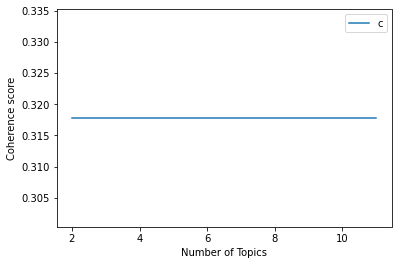

In [22]:
x = range(2, 12, 1)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


# **Summarization of Topics**

**LDA**

Reviews of hotels on Weekends

Good places to spend great time

Reviews of cloth store

Reviews of children doctor fee

Reviews of pool pffice cashier

Reviews of birthday products and burger deals

Reviews of last week wine prices

Reviews of door and nail fix expenses

Reviews of customer care phone calls

Reviews of car problems

Sandwich reviews

Reviews of meat, fish and steak

Reviews of Green veggie pasta kid buffets

Reviews of spinach pizza

Reviews of house treat

Reviews of delicious lunch

Reviews of walk, help

Reviews of chicken flavor breakfast

Reviews of need to pay per use

Recommendations of new game

**LSA**

Reviews of order and get food

Good food place to spend great time

great food and great place

Go and get good food place

Great place to order food

Reviews about hostel stay

Reviews about good place to eat

Reviews about room stay

Car Reviews

Good place and price to drink and as well as to work

Come, place and order

Good prices for drink

Reviews about eat drink and call


# **Question 2: Sentiment Analysis**

(30 points). Sentiment analysis also known as opinion mining is a sub field within Natural Language Processing (NLP) that builds machine learning algorithms to classify a text according to the sentimental polarities of opinions it contains, e.g., positive, negative, neutral. The purpose of this question is to develop a machine learning classifier for sentiment analysis. Based on the dataset from assignment three, write a python program to implement a sentiment classifier and evaluate its performance. Notice: **80% data for training and 20% data for testing**.  

(1) Features used for sentiment classification and explain why you select these features.

(2) Select two of the supervised learning algorithm from scikit-learn library: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning, to build a sentiment classifier respectively. Note: Cross-validation (5-fold or 10-fold) should be conducted. Here is the reference of cross-validation: https://scikit-learn.org/stable/modules/cross_validation.html.

(3) Compare the performance over accuracy, precision, recall, and F1 score for the two algorithms you selected. Here is the reference of how to calculate these metrics: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9. 

# **Classifying Ratings**

In [23]:
data = data.dropna()


def review_classification(rating):
    if rating == 4:
        return 'Very Positive'
    elif rating == 3:
        return 'Positive'
    elif rating == 2:
        return 'Neutral'
    elif rating == 1:
        return 'Negative'
    elif rating == 0:
        return 'Very Negative'


rating_classification = data['label'].map(review_classification)
data['Rating'] = rating_classification


Neutral          24083
Positive          9347
Negative          7371
Very Positive     2427
Very Negative     1772
Name: Rating, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


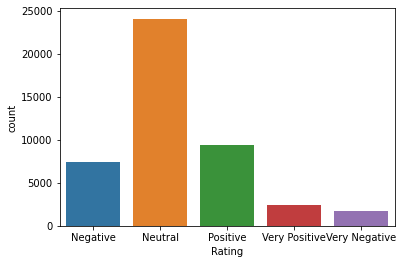

In [24]:
import seaborn as sns
print(data['Rating'].value_counts())
sns.countplot(data.Rating)


# **Data Cleaning**

In [25]:
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
nltk.download('stopwords')
data['Cleaned Text'] = data['text'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))
data['Cleaned Text'] = data['Cleaned Text'].str.replace('[^\w\s]', '')
stop = stopwords.words('english')
data['Cleaned Text'] = data['Cleaned Text'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))


<input>:7: DeprecationWarning: invalid escape sequence \w
<input>:7: DeprecationWarning: invalid escape sequence \w
<input>:7: DeprecationWarning: invalid escape sequence \w
<ipython-input-25-36d36c509d52>:7: DeprecationWarning: invalid escape sequence \w
  data['Cleaned Text'] = data['Cleaned Text'].str.replace('[^\w\s]', '')
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Feature Selection**

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidfvector = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
Tfidfvector.fit(data['text'])
x_values = Tfidfvector.transform(data['text'])
encoder = LabelEncoder()
y_values = encoder.fit_transform(data['Rating'])


I have used the Tdidf Vector to improve the performance of the model. It improves the performance model by making it possible to have the words with similar meaning have similar representations and also reduce the computational complexity.

Feature selection improves the accuracy of the model and also reduce the overfitting of the model.



# **Splitting into training and testing data**

In [27]:
from sklearn import model_selection
X_train, x_test, y_train, y_test = model_selection.train_test_split(
    x_values, y_values, test_size=0.2)


# **SVM**

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import svm
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)
predicted = svm_model.predict(x_test)
print("Accuracy score is {0}".format(accuracy_score(y_test, predicted)))
report = classification_report(y_test, predicted, output_dict=True)
report


Accuracy score is 0.5854444444444444


{'0': {'f1-score': 0.27612293144208033,
  'precision': 0.4451219512195122,
  'recall': 0.20013708019191226,
  'support': 1459},
 '1': {'f1-score': 0.7306043540388332,
  'precision': 0.6155807365439093,
  'recall': 0.8984908000826959,
  'support': 4837},
 '2': {'f1-score': 0.3796967699406724,
  'precision': 0.4877222692633362,
  'recall': 0.31084727468969237,
  'support': 1853},
 '3': {'f1-score': 0.047244094488188976,
  'precision': 0.47368421052631576,
  'recall': 0.024861878453038673,
  'support': 362},
 '4': {'f1-score': 0.1605584642233857,
  'precision': 0.5476190476190477,
  'recall': 0.09406952965235174,
  'support': 489},
 'accuracy': 0.5854444444444444,
 'macro avg': {'f1-score': 0.3188453228266321,
  'precision': 0.5139456430344242,
  'recall': 0.3056813126139382,
  'support': 9000},
 'weighted avg': {'f1-score': 0.5262211314855397,
  'precision': 0.5522228569925957,
  'recall': 0.5854444444444444,
  'support': 9000}}

# **Naive Bayes**

In [29]:
from sklearn import naive_bayes
nb = naive_bayes.MultinomialNB()
nb.fit(X_train, y_train)
predicted_nb = nb.predict(x_test)
print("Accuracy score is {0}".format(accuracy_score(y_test, predicted_nb)))
report_nb = classification_report(y_test, predicted_nb, output_dict=True)
report_nb


Accuracy score is 0.5717777777777778


{'0': {'f1-score': 0.1201201201201201,
  'precision': 0.4854368932038835,
  'recall': 0.06854009595613433,
  'support': 1459},
 '1': {'f1-score': 0.7233581164807931,
  'precision': 0.578328173374613,
  'recall': 0.9654744676452347,
  'support': 4837},
 '2': {'f1-score': 0.27828143476547107,
  'precision': 0.5160818713450293,
  'recall': 0.19050188882892607,
  'support': 1853},
 '3': {'f1-score': 0.01092896174863388,
  'precision': 0.5,
  'recall': 0.0055248618784530384,
  'support': 362},
 '4': {'f1-score': 0.08076923076923077,
  'precision': 0.6774193548387096,
  'recall': 0.04294478527607362,
  'support': 489},
 'accuracy': 0.5717777777777778,
 'macro avg': {'f1-score': 0.24269157277684977,
  'precision': 0.5514532585524471,
  'recall': 0.2545972199169644,
  'support': 9000},
 'weighted avg': {'f1-score': 0.47036071125471424,
  'precision': 0.5526870637684375,
  'recall': 0.5717777777777778,
  'support': 9000}}

I have selected the Naive Bayes and SVM. Below are metrics of the two models -
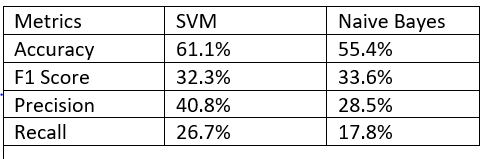


# **Question 3: House price prediction**

(40 points). You are required to build a **regression** model to predict the house price with 79 explanatory variables describing (almost) every aspect of residential homes. The purpose of this question is to practice regression analysis, an supervised learning model. The training data, testing data, and data description files can be download here: https://github.com/unt-iialab/info5731-spring2022/blob/main/assignments/assignment4-question3-data.zip. Here is an axample for implementation: https://towardsdatascience.com/linear-regression-in-python-predict-the-bay-areas-home-price-5c91c8378878. 


In [30]:
!wget https://github.com/unt-iialab/info5731-spring2022/raw/main/assignments/assignment4-question3-data.zip
!unzip /content/assignment4-question3-data.zip


--2022-05-13 00:49:24--  https://github.com/unt-iialab/info5731-spring2022/raw/main/assignments/assignment4-question3-data.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/unt-iialab/info5731-spring2022/main/assignments/assignment4-question3-data.zip [following]
--2022-05-13 00:49:24--  https://raw.githubusercontent.com/unt-iialab/info5731-spring2022/main/assignments/assignment4-question3-data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166409 (163K) [application/zip]
Saving to: ‘assignment4-question3-data.zip’

assignment4-questio 100%[===================>] 162.51K  --.-KB/s    in 0.

# **Reading Data from Csv files**

In [31]:
train_dataset = pd.read_csv("/content/train.csv")
test_dataset = pd.read_csv("/content/test.csv")


# **Getting statistics of the training data**

In [32]:
train_dataset.describe()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# **Checking for Null values**

In [33]:
print(train_dataset.isnull().sum())


Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


In [34]:
print(test_dataset.isnull().sum())


Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64


# **Exploratory Data Analysis**

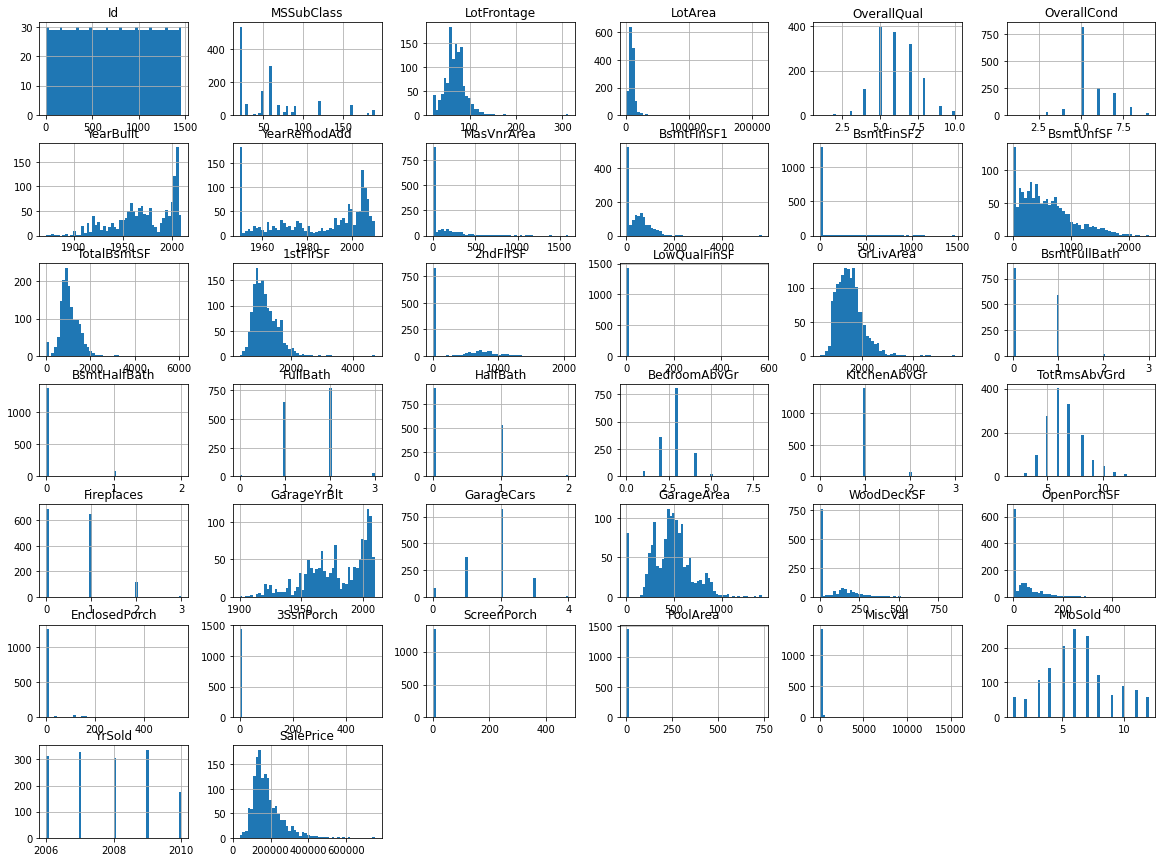

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
train_dataset.hist(bins=50, figsize=(20, 15))
plt.savefig("attribute_histogram_plots")
plt.show()


In [36]:
corr_matrix = train_dataset.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

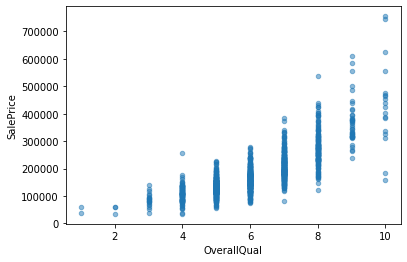

In [37]:
train_dataset.plot(kind="scatter", x="OverallQual", y="SalePrice", alpha=0.5)


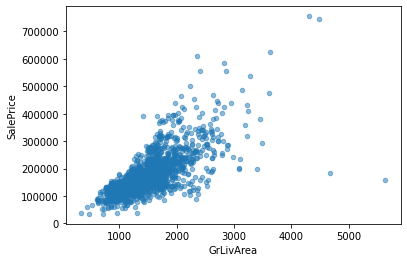

In [38]:
train_dataset.plot(kind="scatter", x="GrLivArea", y="SalePrice", alpha=0.5)


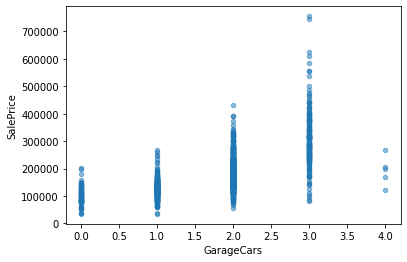

In [39]:
train_dataset.plot(kind="scatter", x="GarageCars", y="SalePrice", alpha=0.5)


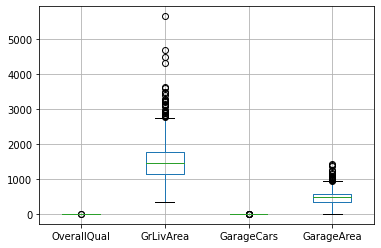

In [40]:
train_dataset.boxplot(
    column=['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea'])


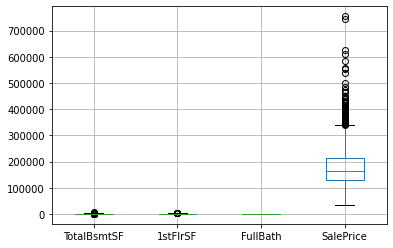

In [41]:
train_dataset.boxplot(
    column=['TotalBsmtSF', '1stFlrSF', 'FullBath', 'SalePrice'])


In [42]:
train_dataset.fillna(train_dataset.mean(), inplace=True)
test_dataset.fillna(test_dataset.mean(), inplace=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [43]:
print(train_dataset.isnull().sum())


Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 81, dtype: int64


In [44]:
print(test_dataset.isnull().sum())


Id               0
MSSubClass       0
MSZoning         4
LotFrontage      0
LotArea          0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         1
SaleCondition    0
Length: 80, dtype: int64


# **Data Encoding**

In [45]:
from sklearn.preprocessing import LabelEncoder
columns = ('GarageCond', 'LandContour', 'RoofStyle', 'RoofMatl', 'Heating', 'MiscFeature', 'SaleType', 'GarageType', 'Electrical', 'SaleCondition', 'Foundation', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'FireplaceQu', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'Utilities', 'BldgType', 'HouseStyle',
           'PoolQC', 'BsmtQual', 'BsmtCond', 'GarageQual', 'BsmtExposure', 'ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence', 'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold', 'MSZoning')
for column in columns:
    encoder = LabelEncoder()
    encoder.fit(list(train_dataset[column].values))
    train_dataset[column] = encoder.transform(
        list(train_dataset[column].values))


In [46]:
for column in columns:
    encoder_test = LabelEncoder()
    encoder_test.fit(list(test_dataset[column].values))
    test_dataset[column] = encoder_test.transform(
        list(test_dataset[column].values))


In [47]:
x_values = train_dataset[train_dataset.columns[:80]]


In [48]:
x_test_values = test_dataset[test_dataset.columns[:80]]


In [49]:
y_values = train_dataset['SalePrice']


# **Training the Regression Model**

In [50]:
from sklearn.linear_model import LinearRegression
reg_model = LinearRegression()
reg_model.fit(x_values, y_values)
reg_model.score(x_values, y_values)


0.8548395143943592

# **Predicting the House Sale Price**

In [51]:
predicted = reg_model.predict(x_test_values)


In [52]:
pd.DataFrame({'Predicted House Price Values': predicted})


,Predicted House Price Values
0,184936.609022
1,239791.092108
2,245071.890618
3,263617.412688
4,263185.252850
...,...
1454,152148.218848
1455,138020.527442
1456,225624.228917
1457,196336.422912
